In [1]:
from diffusers import StableDiffusionPipeline
from diffusers.schedulers import DDIMScheduler, SchedulerMixin
import torch
from typing import Union, List, Optional, Callable, Dict, Any

class StableDiffusionPipelineContinuous(StableDiffusionPipeline):
  def __init__(
    self,
    vae,
    text_encoder,
    tokenizer,
    unet,
    scheduler,
    safety_checker,
    feature_extractor,
    scheduler2: SchedulerMixin,
    requires_safety_checker: bool = True,
    length: int = 1,
  ):
    super().__init__(vae, text_encoder, tokenizer, unet, scheduler, safety_checker, feature_extractor, requires_safety_checker)
    self.register_modules(scheduler2=scheduler2)
    self.length = length
    

  @torch.no_grad()
  def __call__(
    self,
    prompt: Union[str, List[str]] = None,
    height: Optional[int] = None,
    width: Optional[int] = None,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    negative_prompt: Optional[Union[str, List[str]]] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
    latents: Optional[torch.FloatTensor] = None,
    prompt_embeds: Optional[torch.FloatTensor] = None,
    negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    output_type: Optional[str] = "pil",
    return_dict: bool = True,
    callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
    callback_steps: int = 1,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    guidance_rescale: float = 0.0,
  ):
    # 0. Default height and width to unet
    height = height or self.unet.config.sample_size * self.vae_scale_factor
    width = width or self.unet.config.sample_size * self.vae_scale_factor

    # 1. Check inputs. Raise error if not correct
    self.check_inputs(
      prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
    )

    # 2. Define call parameters
    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]

    device = self._execution_device
    print('device', device)
    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # 3. Encode input prompt
    text_encoder_lora_scale = (
      cross_attention_kwargs.get("scale", None) if cross_attention_kwargs is not None else None
    )
    prompt_embeds = self._encode_prompt(
      prompt,
      device,
      num_images_per_prompt,
      do_classifier_free_guidance,
      negative_prompt,
      prompt_embeds=prompt_embeds,
      negative_prompt_embeds=negative_prompt_embeds,
      lora_scale=text_encoder_lora_scale,
    )
    print('prompt embedding:', prompt_embeds.shape)
    
    # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

    # 5. Prepare latent variables
    num_channels_latents = self.unet.config.in_channels
    latents = self.prepare_latents(
      batch_size * num_images_per_prompt,
      num_channels_latents,
      height,
      width,
      prompt_embeds.dtype,
      device,
      generator,
      latents,
    )

    initial_latents = torch.clone(latents)

    # 7. Denoising loop
    total_step = num_inference_steps * self.length
    images = []
    with self.progress_bar(total=total_step) as progress_bar:
      for k in range(self.length):
        new_noise = torch.rand(list(latents.size()), dtype=torch.float16).to(device)
        latents = torch.clone(initial_latents) + new_noise * 1e-2
        latents = (latents - torch.mean(latents)) / torch.std(latents)
        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # if k > 0:
        #   self.scheduler2.set_timesteps(num_inference_steps, device=device)
        #   timesteps = self.scheduler.timesteps
    
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        print('timesteps: ', timesteps)
        print('latents:', latents.shape, torch.mean(latents), torch.std(latents))
        
        for i, t in enumerate(timesteps):
          # expand the latents if we are doing classifier free guidance
          latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
          
          latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
          # if k == 0:
          #   latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
          # else:
          #   latent_model_input = self.scheduler2.scale_model_input(latent_model_input, t)
          # print('latent model input: ', latent_model_input.shape, latent_model_input.dtype)
  
          # predict the noise residual
          noise_pred = self.unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            cross_attention_kwargs=cross_attention_kwargs,
            return_dict=False,
          )[0]
          # print('noise pred: ', noise_pred.shape)
  
          # perform guidance
          if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
  
          if do_classifier_free_guidance and guidance_rescale > 0.0:
            # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
            noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)
  
          # compute the previous noisy sample x_t -> x_t-1
          latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
          # if k == 0:
          #   latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
          # else:
          #   latents = self.scheduler2.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

          # call the callback, if provided
          if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
            progress_bar.update()
            if callback is not None and i % callback_steps == 0:
              callback(i, t, latents)
  
        print('after denoise', torch.mean(latents), torch.std(latents))
        if not output_type == "latent":
          image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
          image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
          image = latents
          has_nsfw_concept = None

        if has_nsfw_concept is None:
          do_denormalize = [True] * image.shape[0]
        else:
          do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)
        # print(image)
        images += image
        # re-apply noise to latent
        
        
        # re-normalize the latents
        # latents = (latents - torch.mean(latents)) / (torch.std(latents) + 1e-6)
    return images


model_id = 'runwayml/stable-diffusion-v1-5'

pipeline1 = StableDiffusionPipeline.from_pretrained(
  model_id,
  torch_dtype=torch.float16,
  requires_safety_checker=False,
)

pipeline1.enable_xformers_memory_efficient_attention()
pipeline1.safety_checker = None
pipeline1.to('cuda')

scheduler2 = DDIMScheduler(
  beta_start=1e-5,
  beta_end=1e-6,
)
pipeline2 = StableDiffusionPipelineContinuous(
  vae=pipeline1.vae,
  text_encoder=pipeline1.text_encoder,
  tokenizer=pipeline1.tokenizer,
  unet=pipeline1.unet,
  scheduler=pipeline1.scheduler,
  safety_checker=pipeline1.safety_checker,
  feature_extractor=pipeline1.feature_extractor,
  scheduler2=scheduler2,
  requires_safety_checker=False,
  length=10,
)

prompt = 'an image of a dog'

output_images = pipeline2(
  prompt,
  num_inference_steps=40,
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


device cuda:0
prompt embedding: torch.Size([2, 77, 768])


  0%|          | 0/400 [00:00<?, ?it/s]

timesteps:  tensor([976, 951, 951, 926, 901, 876, 851, 826, 801, 776, 751, 726, 701, 676,
        651, 626, 601, 576, 551, 526, 501, 476, 451, 426, 401, 376, 351, 326,
        301, 276, 251, 226, 201, 176, 151, 126, 101,  76,  51,  26,   1],
       device='cuda:0')
latents: torch.Size([1, 4, 64, 64]) tensor(0.0001, device='cuda:0', dtype=torch.float16) tensor(1., device='cuda:0', dtype=torch.float16)
after denoise tensor(0.0729, device='cuda:0', dtype=torch.float16) tensor(0.7773, device='cuda:0', dtype=torch.float16)
timesteps:  tensor([976, 951, 951, 926, 901, 876, 851, 826, 801, 776, 751, 726, 701, 676,
        651, 626, 601, 576, 551, 526, 501, 476, 451, 426, 401, 376, 351, 326,
        301, 276, 251, 226, 201, 176, 151, 126, 101,  76,  51,  26,   1],
       device='cuda:0')
latents: torch.Size([1, 4, 64, 64]) tensor(0.0001, device='cuda:0', dtype=torch.float16) tensor(1., device='cuda:0', dtype=torch.float16)
after denoise tensor(0.0708, device='cuda:0', dtype=torch.float16) tenso

In [2]:
len(output_images)

10

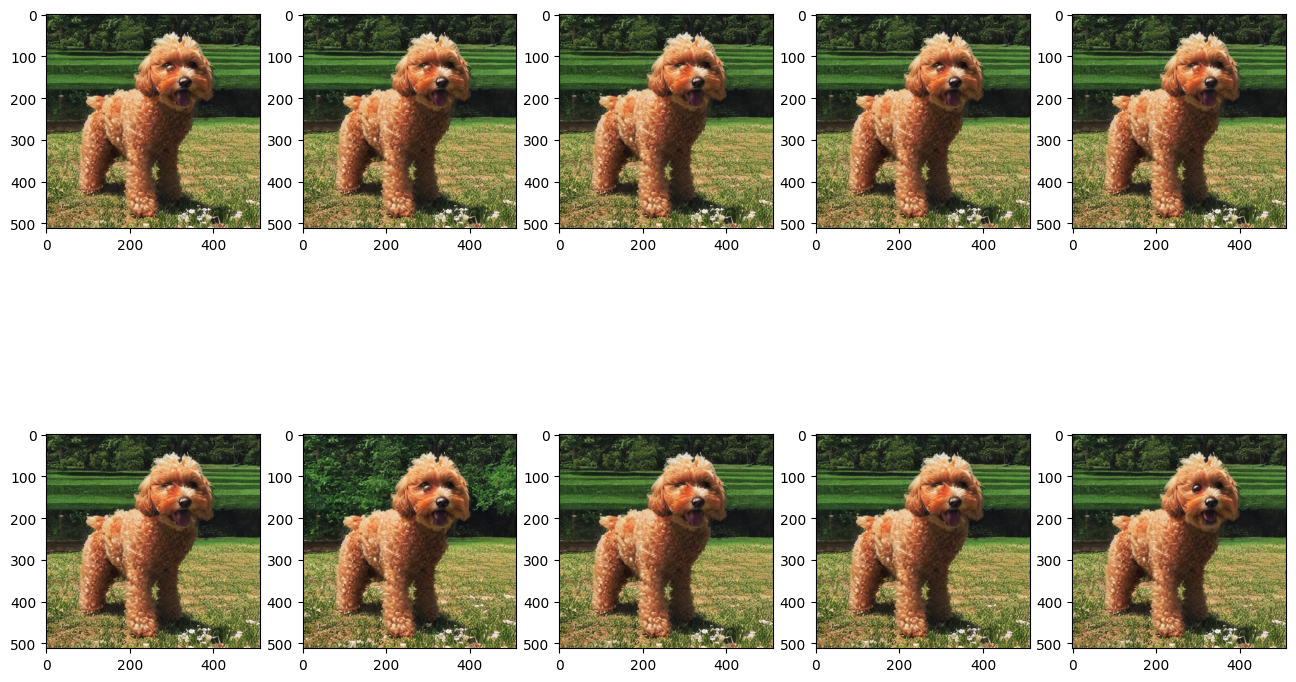

In [3]:
import matplotlib.pyplot as plt

rows = 2
cols = 5
plt.figure(figsize=(16, 10))
for r in range(rows):
  for c in range(cols):
    idx = r * cols + c
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(output_images[idx])
plt.show()

In [4]:
output_images[0].save(
  'animation.gif',
  save_all=True,
  append_images=output_images[1:],
  duration=100,
  loop=0
)

![animated](./animation.gif)